# IMPORTS

In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import Tensor
import scipy.stats as stats
import scipy
from matplotlib.gridspec import SubplotSpec

from torch import nn, optim
from torch.distributions import Distribution

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
#from arff2pandas import a2p
import dill
from sklearn.decomposition import PCA

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# setting random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
from sklearn.metrics import ConfusionMatrixDisplay

from VAE.models import BaseVAEprob, BaseLSTM_VAEprob, Neural_Stat
from generators.generate_data_tfh import SERSGenerator
from utils import plot_sequences,outlier_heuristic, voigt, add_voigt_sequences, create_subtitle, total_reconstruction_err
from read_mapx import RamanExperimentData
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# LOAD DATA

In [2]:
wavelength_cut = 1000

filenames = [
    "data/0ppm_2.mapx",
    "data/0.025ppm_2.mapx",
    "data/0.05ppm_2.mapx",
    "data/0.1ppm_2.mapx",
    "data/0.25ppm_2.mapx",
    "data/0.5ppm_2.mapx",
    "data/0.75ppm_2.mapx",
    "data/1ppm_2.mapx",
    ]

dat_class = RamanExperimentData(filenames=filenames)
spectra, w, mapsize = dat_class.maps[filenames[0]]

In [3]:
full_dataset = []
#validation_dataset = []

print("cutoff just before:",wavelength_cut)
# Cutoff index
idx = np.argmin(np.abs(w-wavelength_cut))
w_cut = w[:idx]

for i in range(len(filenames)):

    dat_class = RamanExperimentData(filenames=filenames)
    spectra, w, mapsize = dat_class.maps[filenames[i]]
    #spectra = spectra.reshape(*mapsize, -1)
    x = torch.from_numpy(spectra).float()
    x = x[:,:idx]
    
    full_dataset.append(x)

full_dataset = torch.cat([s for s in full_dataset])
full_dataset = full_dataset.unsqueeze(2)

cutoff just before: 1000


In [4]:
# dataset for old/new models
train_dataset_old, validation_dataset_old = train_test_split(full_dataset,test_size=0.25, random_state=42)

train_dataset_new,validation_dataset_new = train_test_split(full_dataset,test_size=0.15, random_state=42)

# LOAD MODELS

## NS

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
N_FEATURES = 1
HIDDEN_DIM = 100
BATCH_SIZE = 256
LEARNING_RATE = 5e-4
bidirectional = True
seq_len = idx
BETA1 = 0.01
BETA2 = 0.01

In [6]:
class Encoder_NS(nn.Module):
    def __init__(self, seq_len, n_features, hidden_dim=50, num_layers=1, bidirectional=True,
                 latent_z:int=1, z_layers:int=1, latent_c:int=1):
        super(Encoder_NS, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        #(batch, hidden)
        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]

        hidden_n = hidden_n.reshape(batch_size, -1)
        #print(hidden_n.shape)
        return hidden_n
class Decoder_NS(nn.Module):
    def __init__(self, latent_z:int, z_layers:int, latent_c:int,
                 seq_len, n_features=1, hidden_dim=50, num_layers=1, bidirectional=True):
        super(Decoder_NS, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.latent_z = latent_z
        self.z_layers = z_layers
        self.latent_c = latent_c
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_c+self.latent_z*self.z_layers,
                                          self.hidden_dim)
        
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)
        
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

### OLD NS

In [7]:
LATENT_C = 3
LATENT_Z = 3
Z_LAYERS = 3
NUM_LAYERS = 3

checkpoint = torch.load('NS_data.pkl',map_location = "cpu")

training_info_ns_old = checkpoint['training_info']
validation_info_ns_old = checkpoint['validation_info']
epoch_ns_old = checkpoint['epoch']
# Reloading the model
encoder = Encoder_NS(**checkpoint['encoder_decoder_params']).to(device)
decoder = Decoder_NS(**checkpoint['encoder_decoder_params']).to(device)
model_ns_old = Neural_Stat(Encoder=encoder, Decoder=decoder, **checkpoint["model_params"]).to(device)
model_ns_old.load_state_dict(checkpoint["model"]())
# Reloading the optimizer
optimizer_ns_old = torch.optim.Adam(model_ns_old.parameters(), lr=checkpoint['LEARNING_RATE'])
optimizer_ns_old.load_state_dict(checkpoint["optimizer"])

### NEW NS

In [8]:
LATENT_C = 5
LATENT_Z = 3
Z_LAYERS = 5
NUM_LAYERS = 3

checkpoint = torch.load('NS_data_new.pkl',map_location = "cpu")

training_info_ns_new = checkpoint['training_info']
validation_info_ns_new = checkpoint['validation_info']
epoch_ns_old = checkpoint['epoch']
# Reloading the model
encoder = Encoder_NS(**checkpoint['encoder_decoder_params']).to(device)
decoder = Decoder_NS(**checkpoint['encoder_decoder_params']).to(device)
model_ns_new = Neural_Stat(Encoder=encoder, Decoder=decoder, **checkpoint["model_params"]).to(device)
model_ns_new.load_state_dict(checkpoint["model"]())
# Reloading the optimizer
optimizer_ns_new = torch.optim.Adam(model_ns_new.parameters(), lr=checkpoint['LEARNING_RATE'])
optimizer_ns_new.load_state_dict(checkpoint["optimizer"])

## BASELINE

In [9]:
N_FEATURES=1
HIDDEN_DIM = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
bidirectional = True
BETA = 0.01

In [10]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.latent_features = latent_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        torch.manual_seed(0)
        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        self.fc1 = nn.Linear(
            in_features=self.hidden_dim + int(self.bidirectional) * self.hidden_dim,
            out_features=100)
        
        self.fc2 = nn.Linear(
            in_features=100,
            out_features=2*latent_features)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        x = x.reshape((-1, self.seq_len, self.n_features))

        x, (hidden_n, _) = self.lstm(x)

        if self.bidirectional:
            hidden_n = torch.cat([hidden_n[-1,:, :], hidden_n[-2,:,:]], dim=1).unsqueeze(0)
        else:
            hidden_n = hidden_n[-1, :, :]
        
        #print(hidden_n.shape)

        hidden_n = hidden_n.reshape(batch_size, -1)
        
        #(batch, hidden) -> (batch, 2*latent)
        x = self.fc1(hidden_n)
        x = self.fc2(self.relu(x))

        return x.view(-1, 2*self.latent_features)

class Decoder(nn.Module):

    def __init__(self, seq_len, n_features=1, hidden_dim=50, latent_features=16, num_layers=1, bidirectional=True):
        super(Decoder, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim, self.n_features = hidden_dim, n_features
        self.latent_features = latent_features
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm_depth = self.num_layers + self.num_layers * int(self.bidirectional)
        
        self.latent_to_hidden = nn.Linear(self.latent_features, self.hidden_dim)
        self.hidden_to_mu = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        self.hidden_to_sig = nn.Linear(self.hidden_dim + int(self.bidirectional) * self.hidden_dim, self.n_features)
        
        if torch.cuda.is_available():
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.cuda.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.cuda.FloatTensor)
        else:
            self.decoder_inputs = torch.zeros(self.seq_len, self.n_features, requires_grad=True).type(torch.FloatTensor)
            self.c_0 = torch.zeros(self.lstm_depth, self.hidden_dim, requires_grad=True).type(torch.FloatTensor)


        self.lstm = nn.LSTM(
            input_size=self.n_features,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=self.bidirectional
        )
        
        
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
        # THIS LAYER CAN BE EXCLUDED
        batch_size = x.size(0)
        h_state = self.latent_to_hidden(x)
        
        
        h_0 = torch.stack([h_state for _ in range(self.lstm_depth)])
        #print(f"h_0: {h_0.shape}")
        inputs = torch.stack([self.decoder_inputs for _ in range(batch_size)])
        #print(f"inputs: {inputs.shape}")
        c_inp = torch.stack([self.c_0 for _ in range(batch_size)]).permute(1,0,2).contiguous()
        #print(f"c_inp: {c_inp.shape}")
        
        decoder_output, _ = self.lstm(inputs, (h_0, c_inp))
        #print(f"DECOER OUTPUT: {decoder_output.shape}")
        
        
        out_mu = self.hidden_to_mu(decoder_output).squeeze(-1)
        out_sig = self.hidden_to_sig(decoder_output).squeeze(-1)
        
        out = torch.cat([out_mu, out_sig], axis=1)
        #print(out.shape)
        
        return out

## OLD BASELINE

In [11]:
LATENT_FEATURES = 12
NUM_LAYERS = 2

checkpoint = torch.load('baseline_data.pkl', map_location = "cpu")
print(checkpoint.keys())
training_info_baseline_old = checkpoint['training_info']
validation_info_baseline_old = checkpoint['validation_info']
epoch_baseline_old = checkpoint['epoch']
# Reloading the model
encoder = Encoder(**checkpoint['encoder_decoder_params']).to(device)
decoder = Decoder(**checkpoint['encoder_decoder_params']).to(device)
model_baseline_old = BaseLSTM_VAEprob(encoder=encoder, decoder=decoder, **checkpoint["model_params"]).to(device)
model_baseline_old.load_state_dict(checkpoint["model"]())
# Reloading the optimizer
optimizer_baseline_old = torch.optim.Adam(model_baseline_old.parameters(), lr=checkpoint['LEARNING_RATE'])
optimizer_baseline_old.load_state_dict(checkpoint["optimizer"])

dict_keys(['model', 'model_params', 'LEARNING_RATE', 'encoder_decoder_params', 'optimizer', 'epoch', 'training_info', 'validation_info'])


## NEW BASELINE

In [12]:
LATENT_FEATURES = 12
NUM_LAYERS = 2

checkpoint = torch.load('baseline_data_new.pkl', map_location = "cpu")
print(checkpoint.keys())
training_info_baseline_new = checkpoint['training_info']
validation_info_baseline_new = checkpoint['validation_info']
epoch_baseline_new = checkpoint['epoch']
# Reloading the model
encoder = Encoder(**checkpoint['encoder_decoder_params']).to(device)
decoder = Decoder(**checkpoint['encoder_decoder_params']).to(device)
model_baseline_new = BaseLSTM_VAEprob(encoder=encoder, decoder=decoder, **checkpoint["model_params"]).to(device)
model_baseline_new.load_state_dict(checkpoint["model"]())
# Reloading the optimizer
optimizer_baseline_new = torch.optim.Adam(model_baseline_new.parameters(), lr=checkpoint['LEARNING_RATE'])
optimizer_baseline_new.load_state_dict(checkpoint["optimizer"])

dict_keys(['model', 'model_params', 'LEARNING_RATE', 'encoder_decoder_params', 'optimizer', 'epoch', 'training_info', 'validation_info'])


# EVALUATION

## LOSS PLOTS

In [13]:
loss_info = {
    "NS_NEW":
        {"validation": {name: value for name, value in validation_info_ns_new.items()},
        "training": {name: value for name, value in training_info_ns_new.items()}}
    ,
    "NS_OLD":
        {"validation": {name: value for name, value in validation_info_ns_old.items()},
        "training": {name: value for name, value in training_info_ns_old.items()}}
    ,
    "BASELINE_NEW":
        {"validation": {name: value for name, value in validation_info_baseline_new.items()},
        "training": {name: value for name, value in training_info_baseline_new.items()}}
    ,
    "BASELINE_OLD":
        {"validation": {name: value for name, value in validation_info_baseline_old.items()},
        "training": {name: value for name, value in training_info_baseline_old.items()}}
}
    


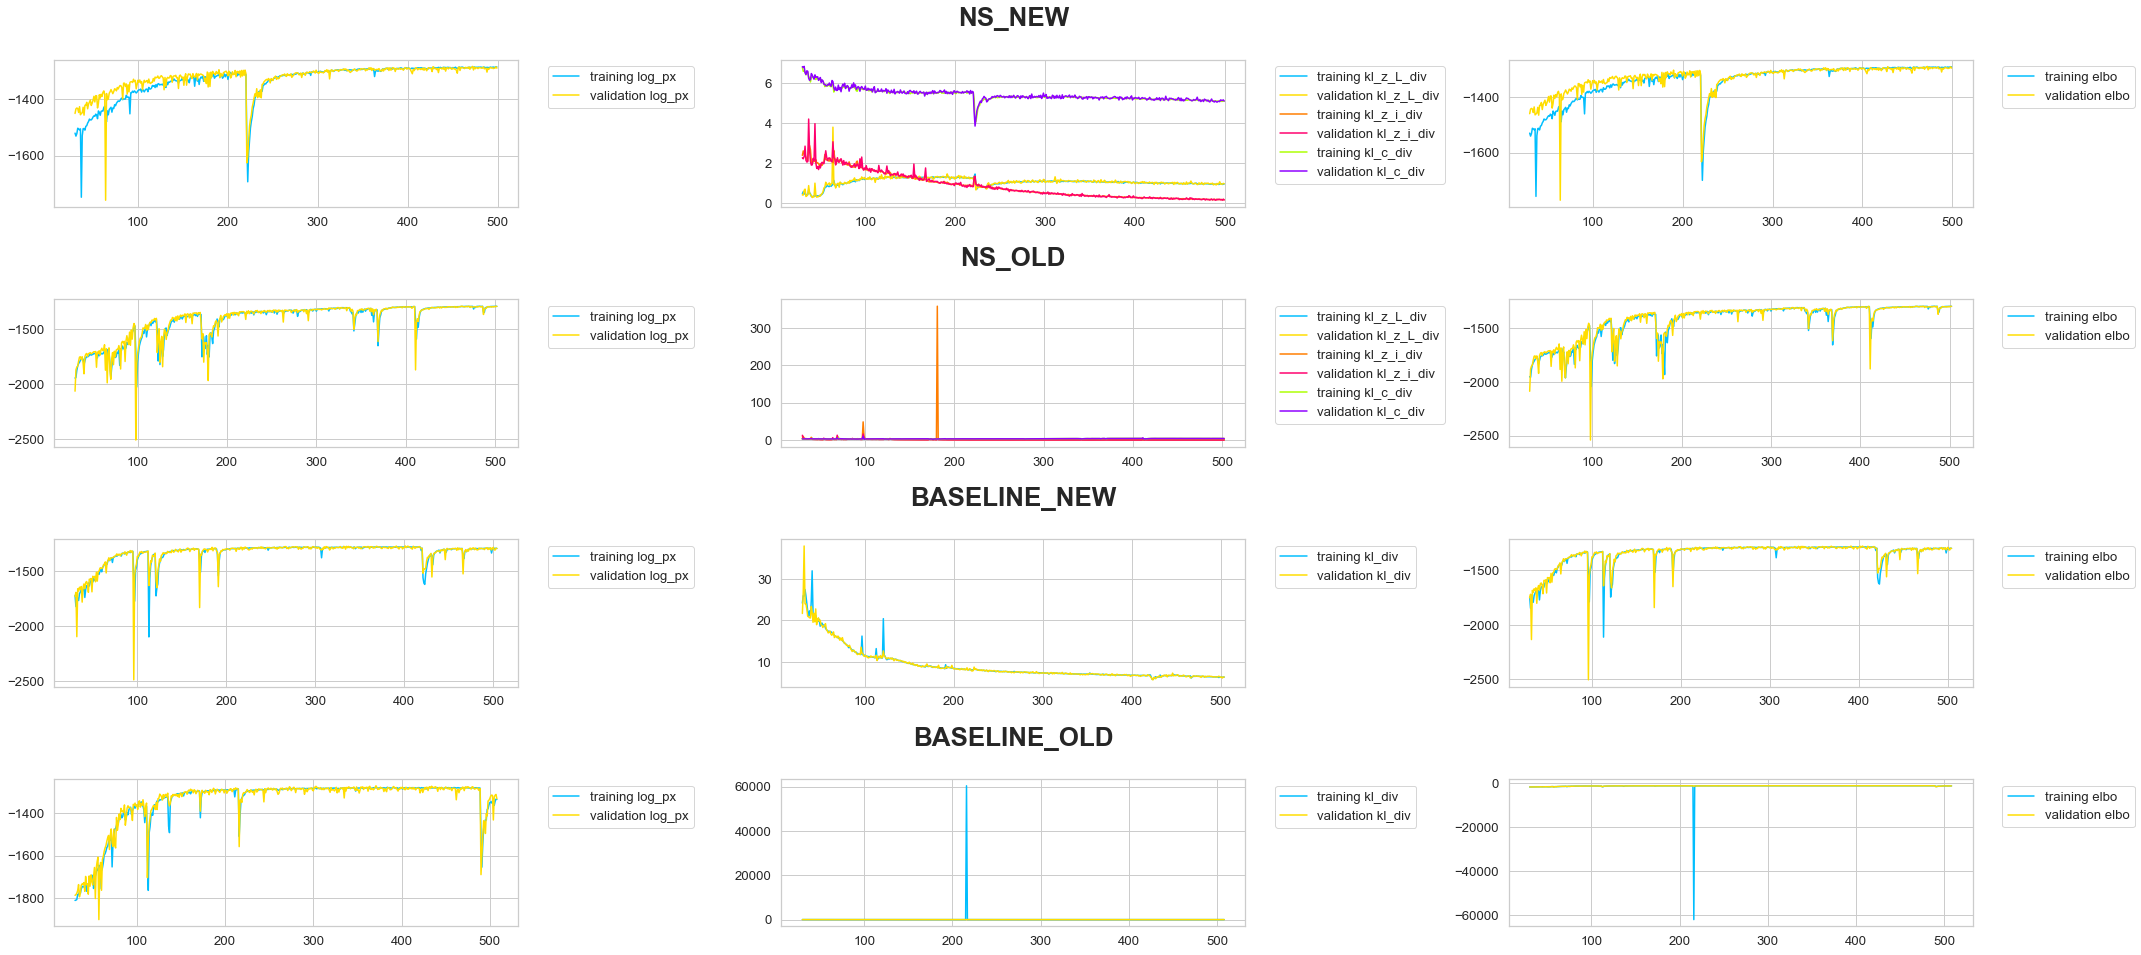

In [14]:
plot_scaler = 1.5
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20*plot_scaler,9*plot_scaler))

grid = plt.GridSpec(4, 3)
for i, (loss_epochs, values) in enumerate(loss_info.items()):
    create_subtitle(fig, grid[i, ::], loss_epochs, 26)


for i, (loss_epochs, values) in enumerate(loss_info.items()):
    training = values["training"]
    validation = values["validation"]
    
    epochs_list = list(range(len(training["elbo"])))[30:]
    
    ax[i, 0].plot(epochs_list, training["log_px"][30:], label="training log_px")
    ax[i, 0].plot(epochs_list, validation["log_px"][30:], label="validation log_px")
    
    if "kl" in training.keys():
        ax[i, 1].plot(epochs_list, training["kl"][30:], label="training kl_div")
        ax[i, 1].plot(epochs_list, validation["kl"][30:], label="validation kl_div")
        
    else:
        ax[i, 1].plot(epochs_list, training["kl_z_L"][30:], label="training kl_z_L_div")
        ax[i, 1].plot(epochs_list, validation["kl_z_L"][30:], label="validation kl_z_L_div")
        
        ax[i, 1].plot(epochs_list, training["kl_z_i"][30:], label="training kl_z_i_div")
        ax[i, 1].plot(epochs_list, validation["kl_z_i"][30:], label="validation kl_z_i_div")
        
        ax[i, 1].plot(epochs_list, training["kl_c"][30:], label="training kl_c_div")
        ax[i, 1].plot(epochs_list, validation["kl_c"][30:], label="validation kl_c_div")
        
    ax[i, 2].plot(epochs_list, training["elbo"][30:], label="training elbo")
    ax[i, 2].plot(epochs_list, validation["elbo"][30:], label="validation elbo")
    
    ax[i, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[i, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[i, 2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
fig.tight_layout()
    

In [14]:
def save_outliers(outliers, directory):
    pd.DataFrame(outliers).to_csv(f"{directory}/outliers.txt", index=False, header=False)

def read_outliers(directory,alpha):
    df = pd.read_csv(f"{directory}/outliers_{alpha}.txt", delimiter= '\s+',header = None)
    return df.iloc[:, 0].to_list()

In [15]:
#NS MODELS
model_ns_old_dir = "model_ns_old"
model_ns_new_dir = "model_ns_new"

# BASELINE MODELS
model_baseline_old_dir = "model_baseline_old"
model_baseline_new_dir = "model_baseline_new"
model_dirs = [model_ns_old_dir, model_ns_new_dir, model_baseline_old_dir, model_baseline_new_dir]

In [16]:
def save_reconstruction_errs(reconstructions, directory):
    pd.DataFrame(reconstructions).to_csv(f"{directory}/recon_errs.txt", index=False, header=False)

def read_reconstruction_errs(directory):
    #print(f"{directory}/recon_errs.txt")
    df = pd.read_csv(f"{directory}/recon_errs.txt", delimiter= '\s+',header = None)
    return df.iloc[:, 0].to_numpy()

In [17]:
LOAD_ERRS = True
if LOAD_ERRS:
    for directory in model_dirs:
        if "ns_old" in directory:
            model_ns_old_sse = read_reconstruction_errs(directory)
            #model_ns_old_sse = model_ns_old_sse / len(validation_dataset_old)
        elif "ns_new" in directory:
            model_ns_new_sse = read_reconstruction_errs(directory)
            #model_ns_new_sse = model_ns_new_sse / len(validation_dataset_new)
        elif "baseline_old" in directory:
            model_baseline_old_sse = read_reconstruction_errs(directory)
            #model_baseline_old_sse = model_baseline_old_sse / len(validation_dataset_old)
        elif "baseline_new" in directory:
            model_baseline_new_sse = read_reconstruction_errs(directory)
            #model_baseline_new_sse = model_baseline_new_sse / len(validation_dataset_new)

In [19]:
#total_reconstruction_err(recon_errs=model_baseline_new_sse)

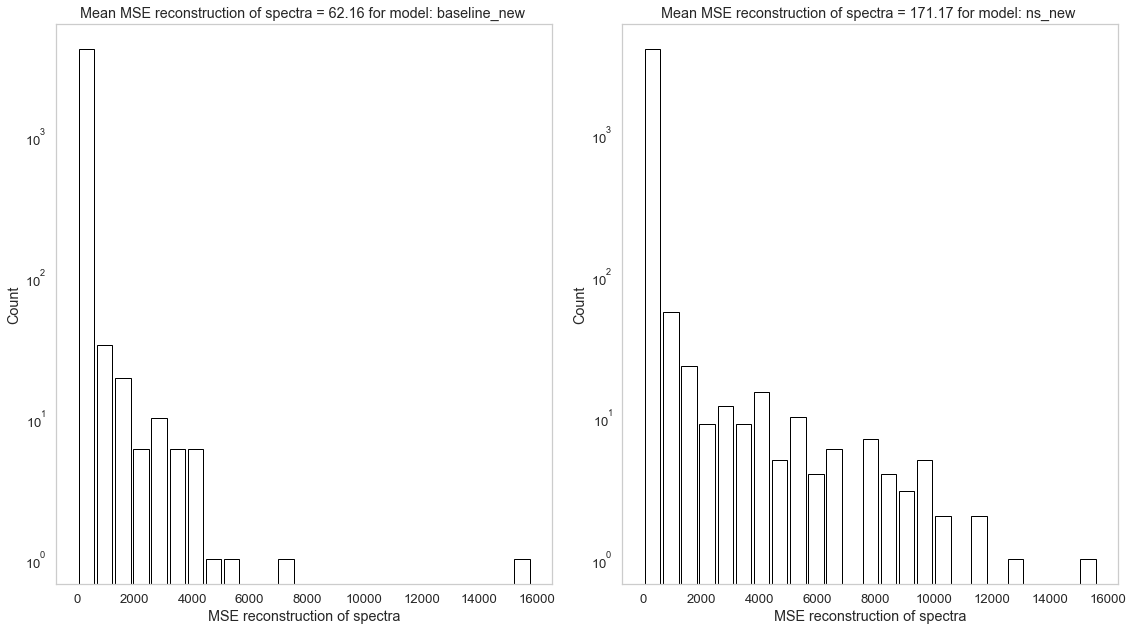

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
#(model_ns_old_sse, "ns_old"), (model_baseline_old_sse, "baseline_old"), 
for i, errs_tup in enumerate([(model_baseline_new_sse, "baseline_new"), (model_ns_new_sse, "ns_new")]):
    ax_i = ax.flatten()[i]
    total_reconstruction_err(recon_errs=errs_tup[0], ax=ax_i)
    ax_i.set_title(f"Mean MSE reconstruction of spectra = {np.round(np.mean(errs_tup[0]), 2)} for model: {errs_tup[1]} ")
    ax_i.set_ylabel("Count")
    ax_i.set_xlabel("MSE reconstruction of spectra")
    ax_i.grid(False)
    
fig.tight_layout()
plt.savefig("figures/mse_models.pdf")

In [18]:
LOAD_OUTLIERS = True

if LOAD_OUTLIERS:
    for directory in model_dirs:
        if "ns_old" in directory:
            outliers_ns_old = read_outliers(directory,'05')
            outliers_ns_old_01 = read_outliers(directory,'01')
        elif "ns_new" in directory:
            outliers_ns_new = read_outliers(directory,'05')
            outliers_ns_new_01 = read_outliers(directory,'01')
        elif "baseline_old" in directory:
            outliers_baseline_old = read_outliers(directory,'05')
            outliers_baseline_old_01 = read_outliers(directory,'01')
        elif "baseline_new" in directory:
            outliers_baseline_new = read_outliers(directory,'05')
            outliers_baseline_new_01 = read_outliers(directory,'01')
else:
    outliers_ns_old = outlier_heuristic(model_ns_old, validation_dataset_old, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_ns_new = outlier_heuristic(model_ns_new, validation_dataset_new, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_baseline_old = outlier_heuristic(model_baseline_old, validation_dataset_old, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_baseline_new = outlier_heuristic(model_baseline_new, validation_dataset_new, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)

In [19]:
## IF THE NS MODEL IS MORE EXPRESSIVE IT SHOULD FIND LESS OUTLIERS IN VALIDATION DATA
print('alpha = 0.05')
print(f"Fraction of outlier in NS vs baseline (NEW MODELS): {len(outliers_ns_new)/len(outliers_baseline_new)}")
print(f"Fraction of outlier in NS vs baseline (OLD MODELS): {len(outliers_ns_old)/len(outliers_baseline_old)}")
print()
print('alpha = 0.01')
print(f"Fraction of outlier in NS vs baseline (NEW MODELS): {len(outliers_ns_new_01)/len(outliers_baseline_new_01)}")
print(f"Fraction of outlier in NS vs baseline (OLD MODELS): {len(outliers_ns_old_01)/len(outliers_baseline_old_01)}")
print("")
print('alpha = 0.05')
print(f"Outliers NEW models NS:{len(outliers_ns_new)} baseline: {len(outliers_baseline_new)} out of {validation_dataset_new.shape[0]}")
print(f"Outliers OLD models NS:{len(outliers_ns_old)} baseline: {len(outliers_baseline_old)} out of {validation_dataset_old.shape[0]}")
print()
print('alpha = 0.01')
print(f"Outliers NEW models NS:{len(outliers_ns_new_01)} baseline: {len(outliers_baseline_new_01)} out of {validation_dataset_new.shape[0]}")
print(f"Outliers OLD models NS:{len(outliers_ns_old_01)} baseline: {len(outliers_baseline_old_01)} out of {validation_dataset_old.shape[0]}")

alpha = 0.05
Fraction of outlier in NS vs baseline (NEW MODELS): 0.9154929577464789
Fraction of outlier in NS vs baseline (OLD MODELS): 0.3923076923076923

alpha = 0.01
Fraction of outlier in NS vs baseline (NEW MODELS): 1.25
Fraction of outlier in NS vs baseline (OLD MODELS): 0.4329896907216495

alpha = 0.05
Outliers NEW models NS:65 baseline: 71 out of 4172
Outliers OLD models NS:102 baseline: 260 out of 6953

alpha = 0.01
Outliers NEW models NS:25 baseline: 20 out of 4172
Outliers OLD models NS:42 baseline: 97 out of 6953


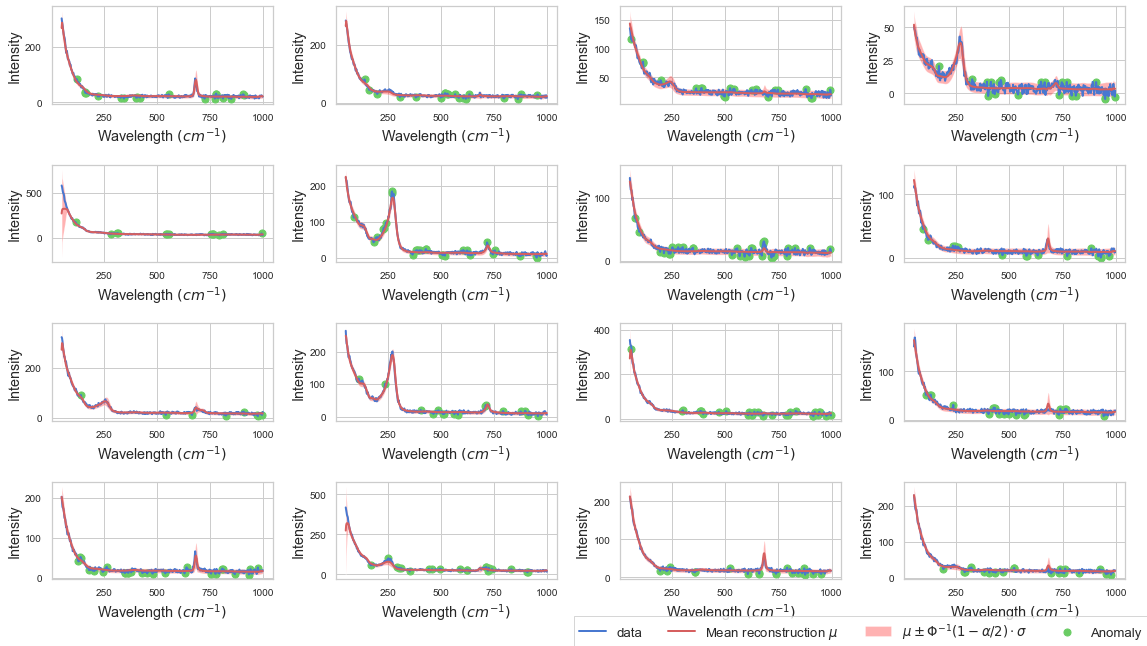

In [23]:
np.random.seed(RANDOM_SEED)
SAMPLES_OLD = np.random.choice(len(validation_dataset_old), size=16, replace=False)
plot_sequences(model_ns_old, w_cut, validation_dataset_old, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=16, samples=SAMPLES_OLD)

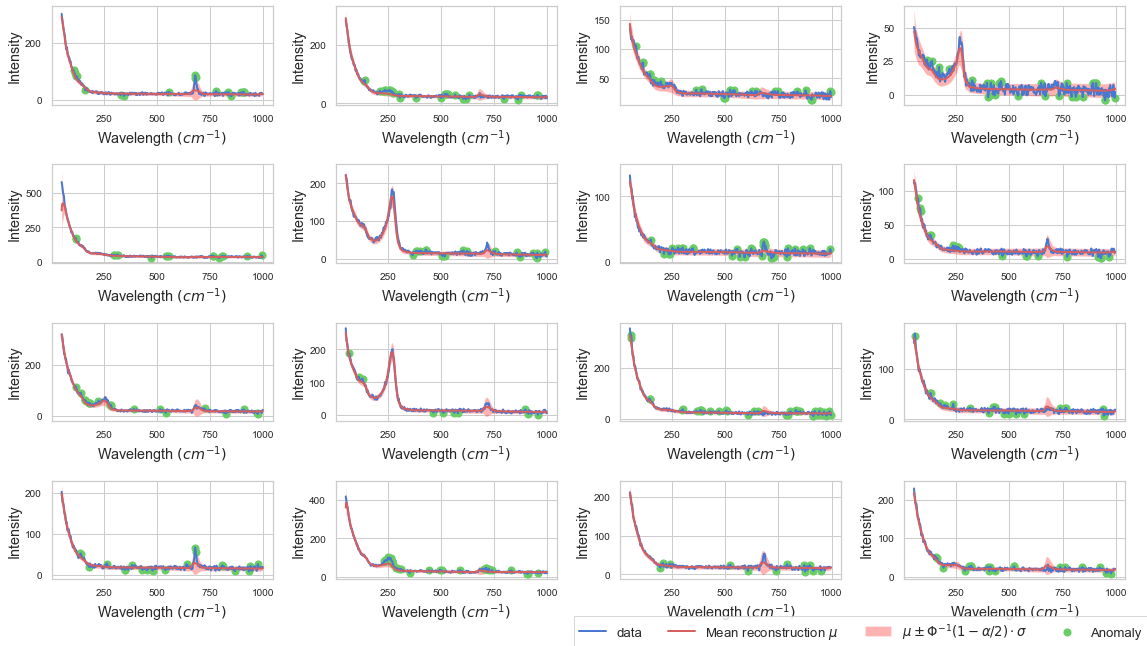

In [24]:
plot_sequences(model_baseline_old, w_cut, validation_dataset_old, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=16, samples=SAMPLES_OLD)

In [84]:
def plot_sequences(model, w, PLOT_DATA, NUM_PLOTS=9, ANOMALY_THRESHOLD=0.1, samples=None, save_dir=None,size=None):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #max_val = PLOT_DATA.max()
    #min_val = PLOT_DATA.min()
    if samples is None:
        samples = np.random.choice(len(PLOT_DATA), replace=False, size=NUM_PLOTS)
    fig, axes = plt.subplots(nrows=int(np.sqrt(NUM_PLOTS)), ncols=int(np.sqrt(NUM_PLOTS)))
    if size is None:
        fig.set_size_inches(16, 9)
    else:
        fig.set_size_inches(*size)
    for i, ax in enumerate(axes.flat):
    
        dataset_idx = samples[i]
        
        dat = PLOT_DATA[dataset_idx].to(device).unsqueeze(0)
    
        with torch.no_grad():
            outputs = model.reconstruction(dat)
        mu = outputs["px"].mu.view(-1).detach().cpu().numpy()
        sigma = outputs["px"].sigma.view(-1).detach().cpu().numpy()

        probs = outputs["px"].log_prob(dat.view(-1)).exp().detach().cpu().numpy()
        anom_quantile = stats.norm.ppf(1 - ANOMALY_THRESHOLD/2)
        
        #idx = probs < ANOMALY_THRESHOLD

        idx = (dat.view(-1).detach().cpu().numpy()>(mu+anom_quantile*sigma))|(dat.reshape(-1).detach().cpu().numpy()<(mu-anom_quantile*sigma)) 

        anom = np.arange(len(PLOT_DATA[dataset_idx]))[idx.squeeze()]
        anom_x = w[idx.squeeze()]
        #print(dat.view(-1).detach().cpu().numpy()[anom])
        
        ax.plot(w, dat.view(-1).detach().cpu().numpy(), c="b", linewidth=2,label="data")

        ax.plot(w, mu, c="r", linewidth=2,label = r"Mean reconstruction $\mu$")
        ax.fill_between(w, mu-anom_quantile*sigma, mu+anom_quantile*sigma, facecolor='red', alpha=0.3,label =r"$\mu \pm \Phi^{-1}(1-\alpha/2)\cdot \sigma$")        
        ax.scatter(anom_x, dat.view(-1).detach().cpu().numpy()[anom], c="g", s=50, label="Anomaly")
        #ax.set_title(f"Sample {samples[i]}", fontdict={"size": 12})
        ax.set_xlabel(r"Wavelength $(cm^{-1})$")
        ax.set_ylabel(r"Intensity")
        
        #ax.set_ylim(min_val-2*sigma.max(), max_val+2*sigma.max())
        plt.setp(ax.get_xticklabels(), fontsize=10)
        plt.setp(ax.get_yticklabels(), fontsize=10)
    lines, labels = fig.axes[-1].get_legend_handles_labels()
    
    lgd = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.043), fancybox=False, shadow=False, ncol=4)
    fig.tight_layout()
    #fig.subplots_adjust(bottom=0.1)
    
    if save_dir:
        plt.savefig(save_dir,bbox_inches='tight')#, bbox_extra_artists=(lgd,), )
        
    plt.show()

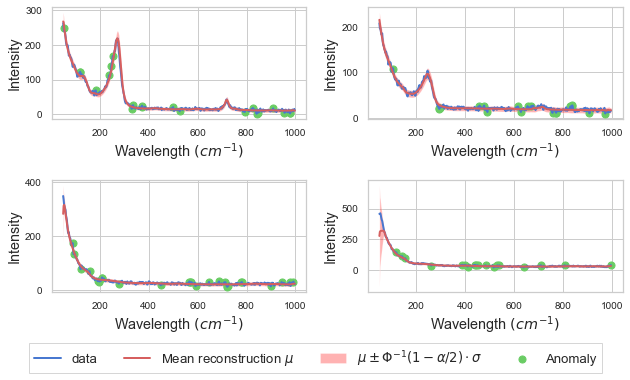

In [85]:
np.random.seed(15)
SAMPLES_NEW = np.random.choice(len(validation_dataset_new), size=4, replace=False)
plot_sequences(model_ns_new, w_cut, validation_dataset_new, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=4, samples=SAMPLES_NEW,save_dir="figures/ns_new_sequences_05.pdf",size=(9,5))

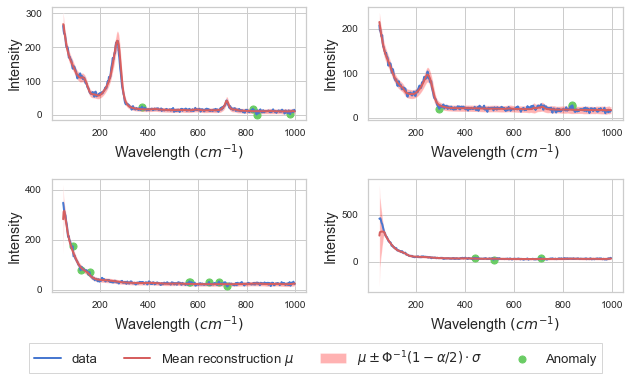

In [86]:
plot_sequences(model_ns_new, w_cut, validation_dataset_new, ANOMALY_THRESHOLD=0.01, NUM_PLOTS=4, samples=SAMPLES_NEW,size=(9,5))

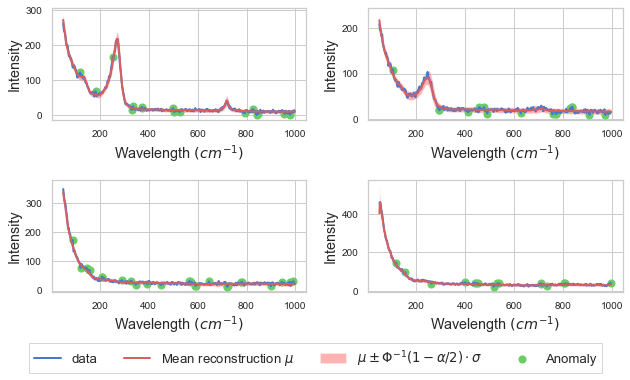

In [87]:
plot_sequences(model_baseline_new, w_cut, validation_dataset_new, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=4, samples=SAMPLES_NEW, save_dir="figures/baseline_new_sequences_05.pdf",size=(9,5))

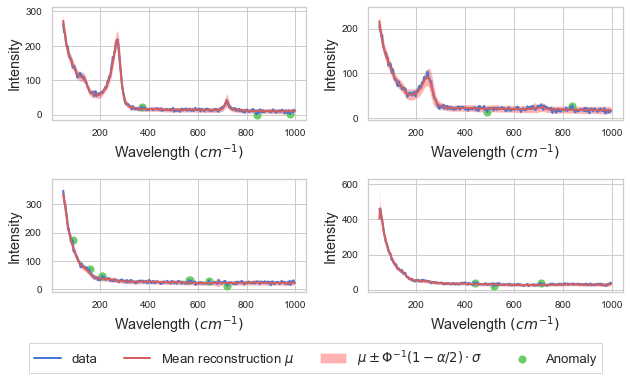

In [88]:
plot_sequences(model_baseline_new, w_cut, validation_dataset_new, ANOMALY_THRESHOLD=0.01, NUM_PLOTS=4, samples=SAMPLES_NEW,size=(9,5))

### ADD VOIGTS TO SAMPLES AND PLOT WITH THESE

In [89]:
voigt_samples_new = add_voigt_sequences(validation_dataset_new.squeeze(), w_cut, plot=False, seed=42)
voigt_samples_old = add_voigt_sequences(validation_dataset_old.squeeze(), w_cut, plot=False, seed=42)

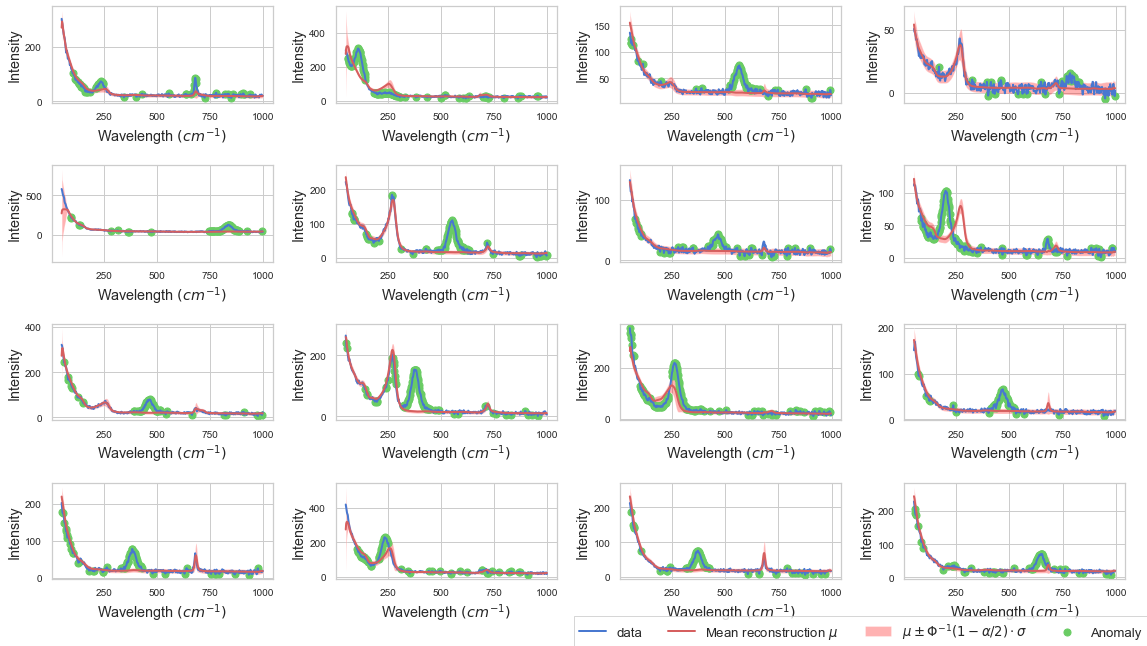

In [28]:
plot_sequences(model_ns_old, w_cut, voigt_samples_old, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=16, samples=SAMPLES_OLD)

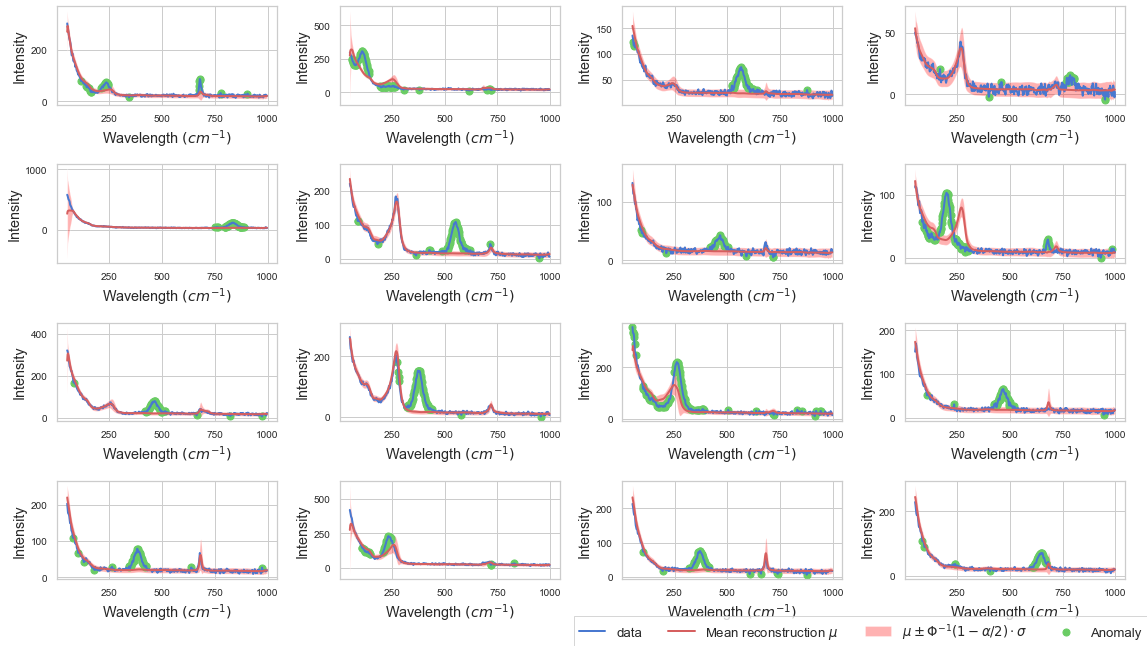

In [29]:
plot_sequences(model_ns_old, w_cut, voigt_samples_old, ANOMALY_THRESHOLD=0.01, NUM_PLOTS=16, samples=SAMPLES_OLD)

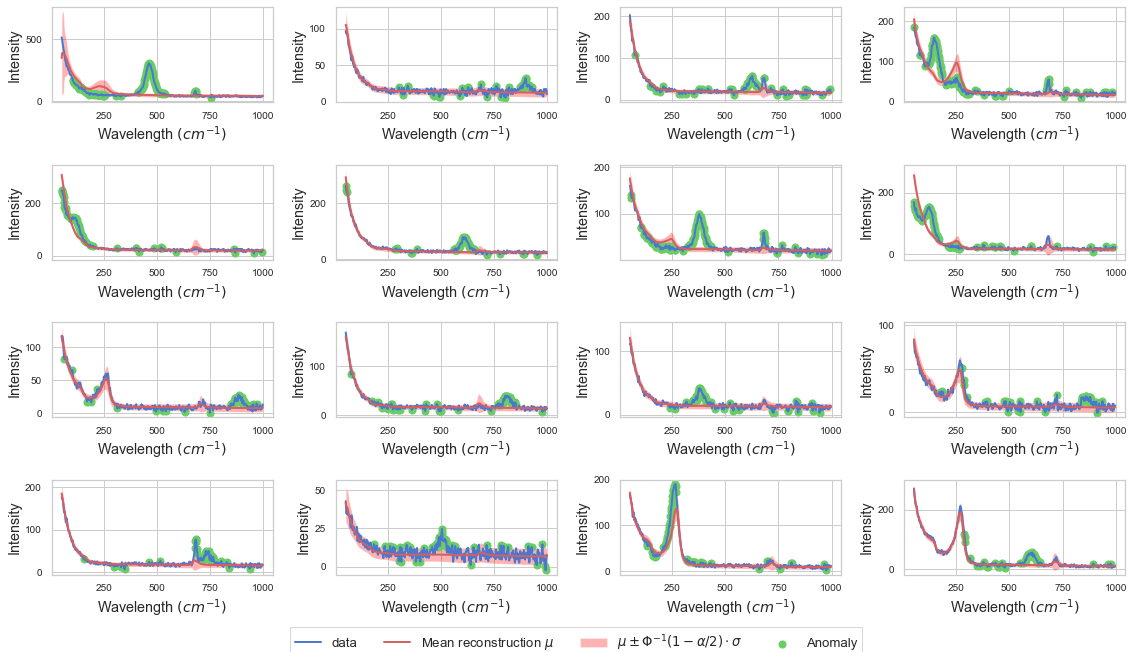

In [29]:
plot_sequences(model_baseline_old, w_cut, voigt_samples_old, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=16, samples=SAMPLES_OLD)

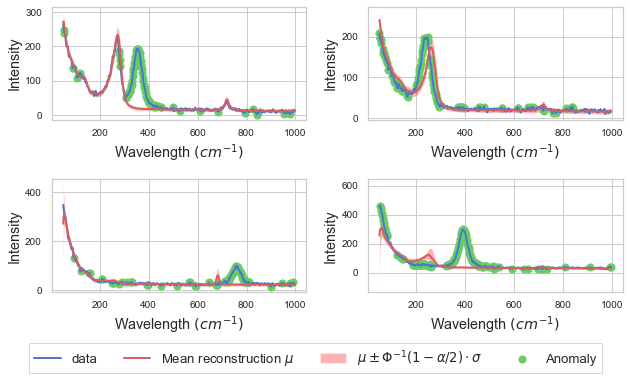

In [90]:
plot_sequences(model_ns_new, w_cut, voigt_samples_new, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=4, samples=SAMPLES_NEW, save_dir="figures/ns_new_voigt_sequences_05.pdf",size=(9,5))

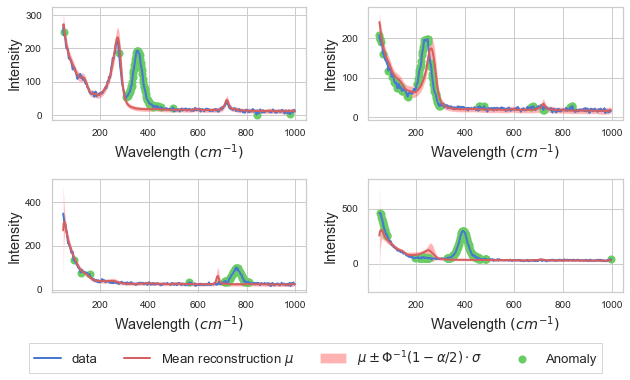

In [91]:
plot_sequences(model_ns_new, w_cut, voigt_samples_new, ANOMALY_THRESHOLD=0.01, NUM_PLOTS=4, samples=SAMPLES_NEW,size=(9,5))

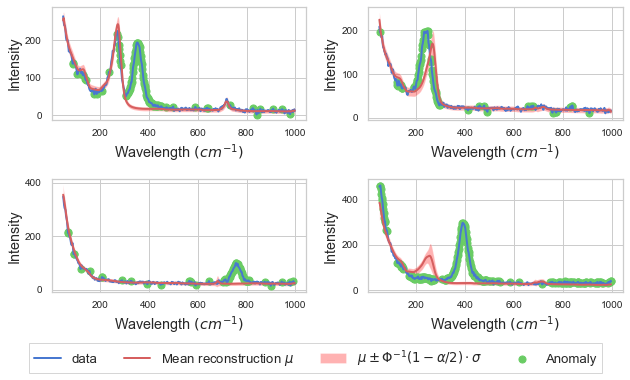

In [92]:
plot_sequences(model_baseline_new, w_cut, voigt_samples_new, ANOMALY_THRESHOLD=0.05, NUM_PLOTS=4, samples=SAMPLES_NEW, save_dir="figures/baseline_new_voigt_sequences_05.pdf",size=(9,5))

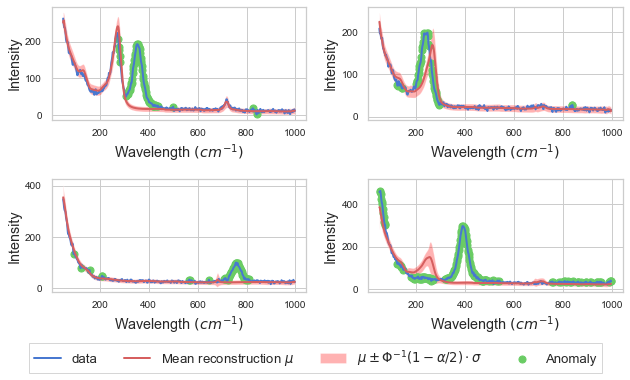

In [93]:
plot_sequences(model_baseline_new, w_cut, voigt_samples_new, ANOMALY_THRESHOLD=0.01, NUM_PLOTS=4, samples=SAMPLES_NEW,size=(9,5))

### OUTLIERS ON VOIGT-ADDED DATA

In [36]:
def save_outliers_voigt(outliers, directory):
    pd.DataFrame(outliers).to_csv(f"{directory}/voigt_outliers.txt", index=False, header=False)

def read_outliers_voigt(directory,alpha):
    df = pd.read_csv(f"{directory}/voigt_outliers_{alpha}.txt", delimiter= '\s+')
    return list(df.iloc[:, 0])

In [37]:
LOAD_VOIGT_OUTLIERS = True
if LOAD_VOIGT_OUTLIERS:
    for directory in model_dirs:
        if "ns_old" in directory:
            outliers_ns_old_voigt = read_outliers_voigt(directory,'05')
            outliers_ns_old_voigt_01 = read_outliers_voigt(directory,'01')
        elif "ns_new" in directory:
            outliers_ns_new_voigt = read_outliers_voigt(directory,'05')
            outliers_ns_new_voigt_01 = read_outliers_voigt(directory,'01')
        elif "baseline_old" in directory:
            outliers_baseline_old_voigt = read_outliers_voigt(directory,'05')
            outliers_baseline_old_voigt_01 = read_outliers_voigt(directory,'01')
        elif "baseline_new" in directory:
            outliers_baseline_new_voigt = read_outliers_voigt(directory,'05')
            outliers_baseline_new_voigt_01 = read_outliers_voigt(directory,'01')
else:
    outliers_ns_old_voigt = outlier_heuristic(model_ns_old, voigt_samples_old, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_baseline_old_voigt = outlier_heuristic(model_baseline_old, voigt_samples_old, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_ns_new_voigt = outlier_heuristic(model_ns_new, voigt_samples_new, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)
    outliers_baseline_new_voigt = outlier_heuristic(model_baseline_new, voigt_samples_new, window_size=15, num_outliers=10, ANOMALY_THRESHOLD=0.05)


In [32]:
print(f"Fraction on voigt-added-samples marked as outliers:")
print(f"NS_OLD: {len(outliers_ns_old_voigt) / len(voigt_samples_old)}")
print(f"BASELINE_OLD: {len(outliers_baseline_old_voigt) / len(voigt_samples_old)}")
print(f"NS_NEW: {len(outliers_ns_new_voigt) / len(voigt_samples_new)}")
print(f"BASELINE_NEW: {len(outliers_baseline_new_voigt) / len(voigt_samples_new)}")

Fraction on voigt-added-samples marked as outliers:


NameError: name 'voigt_samples_old' is not defined

# ROC CURVES

In [38]:
mat_scale_old = len(validation_dataset_new)/len(validation_dataset_old)
np.set_printoptions(suppress=True)

In [39]:
np.random.seed(42)
perm_idx = np.random.permutation(list(range(len(validation_dataset_new))))

In [40]:
perm_idx_first_half = perm_idx[int(0.5*len(perm_idx)):]
perm_idx_second_half = perm_idx[:int(0.5*len(perm_idx))]

In [41]:
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_ns_new:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_ns_new_voigt:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
])

ns_new_disp = ConfusionMatrixDisplay(conf_mat)

tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_ns_new_01:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_ns_new_voigt_01:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
])

ns_new_disp_01 = ConfusionMatrixDisplay(conf_mat)

In [42]:
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_baseline_new:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_baseline_new_voigt:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
])

baseline_new_disp = ConfusionMatrixDisplay(conf_mat)
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_baseline_new_01:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_baseline_new_voigt_01:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
])

baseline_new_disp_01 = ConfusionMatrixDisplay(conf_mat)

In [43]:
np.random.seed(42)
perm_idx = np.random.permutation(list(range(len(validation_dataset_old))))

In [44]:
perm_idx_first_half = perm_idx[int(0.5*len(perm_idx)):]
perm_idx_second_half = perm_idx[:int(0.5*len(perm_idx))]

In [45]:
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_ns_old:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_ns_old_voigt:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
]) * mat_scale_old

ns_old_disp = ConfusionMatrixDisplay(np.round(conf_mat, 0).astype(int))
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_ns_old_01:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_ns_old_voigt_01:
        tp += 1
    else:
        fn += 1
    
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
]) * mat_scale_old

ns_old_disp_01 = ConfusionMatrixDisplay(np.round(conf_mat, 0).astype(int))

In [46]:
tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_baseline_old:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_baseline_old_voigt:
        tp += 1
    else:
        fn += 1
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
]) * mat_scale_old


baseline_old_disp = ConfusionMatrixDisplay(np.round(conf_mat, 0).astype(int))

tp, tn, fp, fn = 0, 0, 0, 0
#this is valid data
for idx in perm_idx_second_half:
    if idx in outliers_baseline_old_01:
        fp += 1
    else:
        tn += 1
# this is voigt data
for idx in perm_idx_first_half:
    if idx in outliers_baseline_old_voigt_01:
        tp += 1
    else:
        fn += 1
        
conf_mat = np.array([
    [tp, fp],
    [fn, tn]
]) * mat_scale_old


baseline_old_disp_01 = ConfusionMatrixDisplay(np.round(conf_mat, 0).astype(int))


### Base old

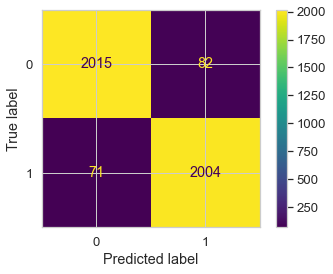

In [48]:
baseline_old_disp.plot()

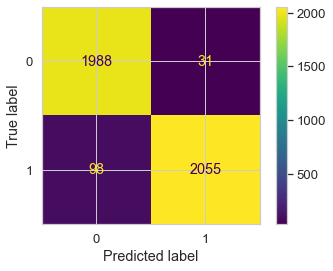

In [49]:
baseline_old_disp_01.plot()

### NS old

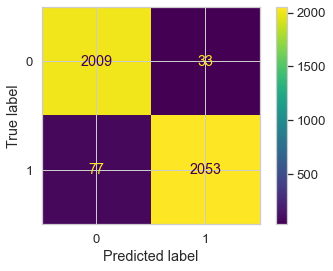

In [50]:
ns_old_disp.plot()

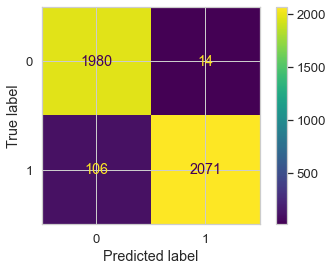

In [51]:
ns_old_disp_01.plot()

### new NS

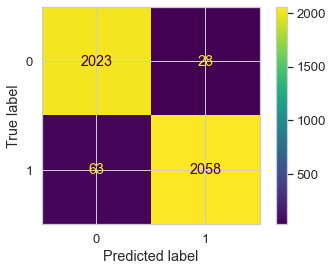

In [52]:
ns_new_disp.plot()

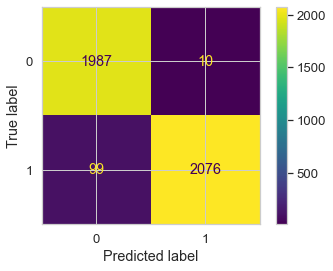

In [56]:
ns_new_disp_01.plot()

### Base new

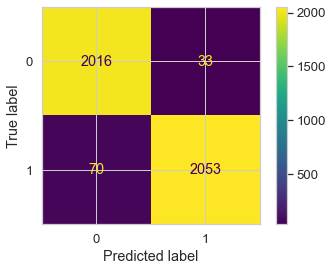

In [54]:
baseline_new_disp.plot()

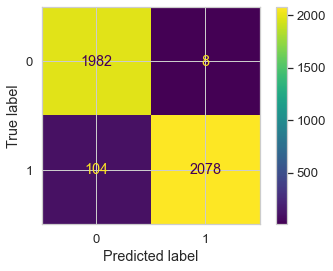

In [55]:
baseline_new_disp_01.plot()

In [60]:
model_ns_old

Neural_Stat(
  (encode_h): Encoder_NS(
    (lstm): LSTM(1, 100, num_layers=2, batch_first=True, bidirectional=True)
  )
  (encode_c): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=6, bias=False)
  )
  (encode_z_from_h_c): Sequential(
    (0): Linear(in_features=203, out_features=203, bias=True)
    (1): ReLU()
    (2): Linear(in_features=203, out_features=203, bias=True)
    (3): ReLU()
    (4): Linear(in_features=203, out_features=6, bias=False)
  )
  (posterior_z_from_z): Sequential(
    (0): Linear(in_features=206, out_features=206, bias=True)
    (1): ReLU()
    (2): Linear(in_features=206, out_features=206, bias=True)
    (3): ReLU()
    (4): Linear(in_features=206, out_features=6, bias=False)
  )
  (decode_c_to_z): Sequential(
    (0): Linear(in_features=3, out_features=50, bias=True)
    (1): ReLU()
    (2): Linea

In [59]:
model_baseline_old

BaseLSTM_VAEprob(
  (encoder): Encoder(
    (lstm): LSTM(1, 100, num_layers=2, batch_first=True, bidirectional=True)
    (fc1): Linear(in_features=200, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=24, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (latent_to_hidden): Linear(in_features=12, out_features=100, bias=True)
    (hidden_to_mu): Linear(in_features=200, out_features=1, bias=True)
    (hidden_to_sig): Linear(in_features=200, out_features=1, bias=True)
    (lstm): LSTM(1, 100, num_layers=2, batch_first=True, bidirectional=True)
    (relu): ReLU()
  )
)

In [125]:
total1 = 0
for i in model_baseline_old.encoder.parameters():
    #print(*i.shape)
    total1 +=np.array([*i.shape]).prod()
print(total1)

total2 = 0
for i in model_baseline_old.decoder.parameters():
    #print(*i.shape)
    total2 +=np.array([*i.shape]).prod()
print(total2)


total = 0
for i in model_baseline_old.parameters():
    #print(*i.shape)
    total +=np.array([*i.shape]).prod()
print(total)
print(total1+total2)



346524
325702
672226
672226


In [126]:
total1 = 0
for i in model_baseline_new.encoder.parameters():
    #print(*i.shape)
    total1 +=np.array([*i.shape]).prod()
print(total1)

total2 = 0
for i in model_baseline_new.decoder.parameters():
    #print(*i.shape)
    total2 +=np.array([*i.shape]).prod()
print(total2)


total = 0
for i in model_baseline_new.parameters():
    #print(*i.shape)
    total +=np.array([*i.shape]).prod()
print(total)
print(total1+total2)


589740
568102
1157842
1157842


In [131]:
total1 = 0
for i in model_ns_old.parameters():
    #print(*i.shape)
    total1 +=np.array([*i.shape]).prod()
print(total1)

total2 = 0
for i in model_ns_old.decode_x_from_z_c.parameters():
    #print(*i.shape)
    total2 +=np.array([*i.shape]).prod()
print(total2)


total = 0
for i in model_ns_old.parameters():
    #print(*i.shape)
    total +=np.array([*i.shape]).prod()
print(total)
print(total1-total2)


908114
325702
908114
582412


In [133]:
total1 = 0
for i in model_ns_new.parameters():
    #print(*i.shape)
    total1 +=np.array([*i.shape]).prod()
print(total1)

total2 = 0
for i in model_ns_new.decode_x_from_z_c.parameters():
    #print(*i.shape)
    total2 +=np.array([*i.shape]).prod()
print(total2)


print(total1-total2)

1396434
568102
828332
